# Heart Failure Incidence Prediction

In this work, using a publicly available heart dataset (described below), we employ a machine learning based approach to predict incidence of heart failure. Using an ensemble of four different algorithms (Logistic Regression, Support Vector Machine, Boosting and K-Nearest Neighbour), incidence of heart failure can be correctly predicted with 0.862 accuracy, as seen through cross validation. 

# Data Source

This dataset considers five independent heart datasets combined. The five datasets are as follows:

    ◉ Cleveland: 303 observations

    ◉ Hungarian: 294 observations

    ◉ Switzerland: 123 observations

    ◉ Long Beach VA: 200 observations

    ◉ Stalog (Heart) Data Set: 270 observations

Final dataset size: 918 entries

Data available from: https://www.kaggle.com/fedesoriano/heart-failure-prediction

Citation: fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

Acknowledgements

Creators:

    ◉ Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
    ◉ University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
    ◉ University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
    ◉ V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor: David W. Aha (aha '@' ics.uci.edu) (714) 856-8779

# Overview of Data

12 Columns with the following information and attributes:

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]


# Initialise Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import Data

In [7]:
#read in data to dataframe
data = pd.read_csv('heart.csv', index_col=False)

#look at data
data.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [8]:
#assign our class we want to predict
heart_class = data["HeartDisease"]
data = data.drop("HeartDisease", axis=1)

#look at our target variable
heart_class.head(5)


0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

## Feature Engineering 

Many of our categorical variables are unsuitable for our analysis in the format we have. The algorithms we have selected to train on this data can benefit from One-Hot-Encoding of our categorical variables. This will generate additional columns for each of the category types and encoded with binary classification (1,0). This will become clearer when we look at the updated dataset. 

In [9]:
# one hot encoding of categorical variables
# creating instance of one-hot-encoder
encoder=OneHotEncoder(sparse=False)

# one hot encoding of categorical variables
# creating instance of one-hot-encoder
encoder=OneHotEncoder(sparse=False)

def encode_categorical_variable_columns(data, column_name):
    data_encoded = pd.DataFrame(encoder.fit_transform(data[[column_name]]))
    
    data_encoded.columns = encoder.get_feature_names([column_name])
    
    data.drop([column_name] ,axis=1, inplace=True)
    
    data = pd.concat([data, data_encoded ], axis=1)

    return data

data = encode_categorical_variable_columns(data, "Sex")
data = encode_categorical_variable_columns(data, "ChestPainType")
data = encode_categorical_variable_columns(data, "RestingECG")
data = encode_categorical_variable_columns(data, "ST_Slope")

#look at updated dataset
data.head(10)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,N,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,N,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,N,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,138,214,0,108,Y,1.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,150,195,0,122,N,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,39,120,339,0,170,N,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6,45,130,237,0,170,N,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7,54,110,208,0,142,N,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,37,140,207,0,130,Y,1.5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,48,120,284,0,120,N,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Data Cleaning

Our "ExerciseAngina" column is encoded with (Y, N), we will convert this to binary encoding (1,0)

In [10]:
# change presence of Exercise Angina to (0,1) instead of (Y, N)
data['ExerciseAngina'] = data['ExerciseAngina'].map({'Y': 1, 'N': 0})
data["ExerciseAngina"].head(5)

0    0
1    0
2    0
3    1
4    0
Name: ExerciseAngina, dtype: int64

When we look at the Cholesterol column, we see that there is a significant number of columns without any information available. We would like to remove these from our analysis.

In [11]:
data["Cholesterol"].value_counts()

0      172
254     11
223     10
220     10
230      9
      ... 
355      1
354      1
353      1
349      1
603      1
Name: Cholesterol, Length: 222, dtype: int64

There are 172 columns which list cholesterol as 0

In [12]:
# cholesterol column has many cells without information - Remove these
clean_data = data[data.Cholesterol != 0]
#repeat for our target variable
clean_heart_class = heart_class[data.Cholesterol != 0]

Looking at the shape of our dataset, we now see we have 746 entries, rather than the original 918.

In [82]:
clean_data.shape

(746, 19)

We will also remove outliers from our dataset

In [13]:
clean_data = clean_data.values

#remove outliers from whole dataset
lof = LocalOutlierFactor()
yhat = lof.fit_predict(clean_data)
# select all rows that are not outliers
mask = yhat != -1
outlier_clean_data, outlier_clean_heart_class = clean_data[mask, :], clean_heart_class[mask]

This further reduces our dataset by 16 rows

In [14]:
outlier_clean_data.shape

(730, 19)

Is our target variable balanced

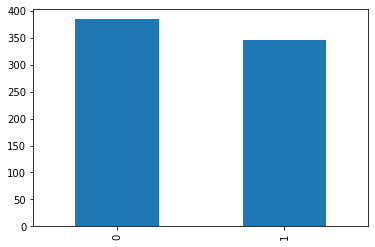

In [86]:
#consider how our binary class variable is balanced
pd.DataFrame(outlier_clean_heart_class)["HeartDisease"].value_counts().plot(kind='bar')


We will consider our target variable well balanced.

# Exploratory Data Analysis

Let's firstly evaluate the distribution of our numeric variables

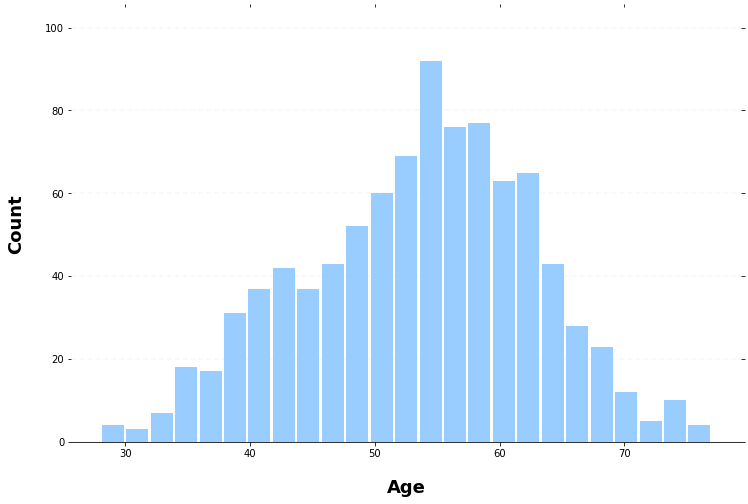

In [18]:
from matplotlib.ticker import StrMethodFormatter

#dictionary of colours for each variable
variable_colour = {'Age': '#99ccff', 'RestingBP': '#ffccff',
                   'Cholesterol': '#00ffcc', 'MaxHR': '#ff5050'}

def plot_distributions(variable):
    ax = data.hist(column=variable, bins=25, grid=False, figsize=(12,8), color=variable_colour[variable], zorder=2, rwidth=0.9)
    
    ax = ax[0]
    for x in ax:
    
        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)
    
        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    
        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    
            # Remove title
            x.set_title("")
        
            # Set x-axis label
            x.set_xlabel(variable, labelpad=20, weight='bold', size=18)
        
            # Set y-axis label
            x.set_ylabel("Count", labelpad=20, weight='bold', size=18)
        
            # Format y-axis label
            x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    return x

age_plot = plot_distributions("Age")

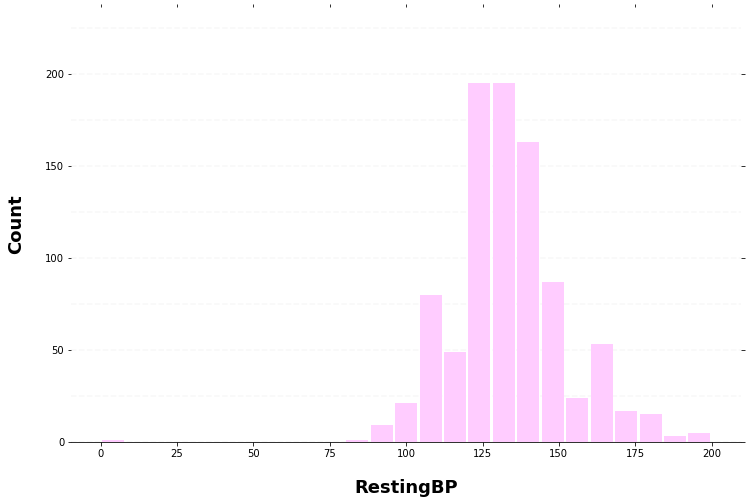

In [106]:
bp_plot = plot_distributions("RestingBP")

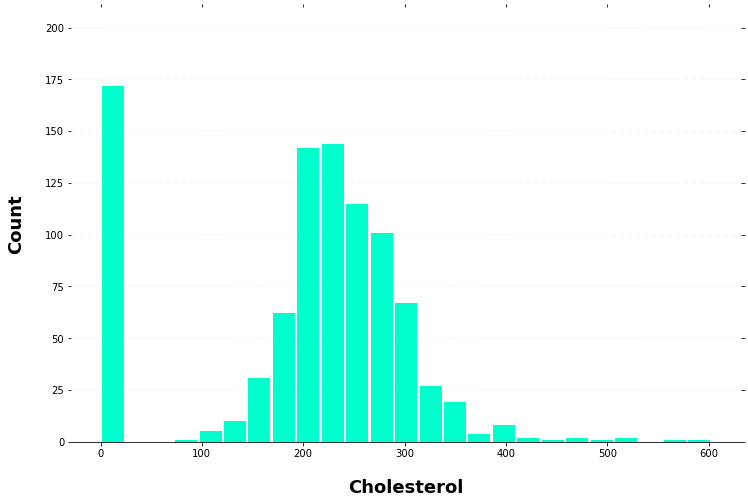

In [107]:
cholesterol_plot = plot_distributions("Cholesterol")

We can see from the cholesterol column the overabundance of O, which we have removed from our cleaned dataset.

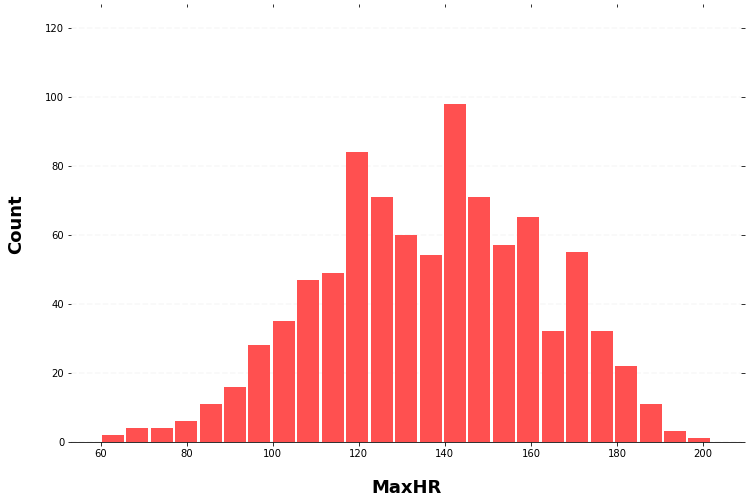

In [108]:
hr_plot = plot_distributions("MaxHR")

How do distributions differ by heart failure classification?

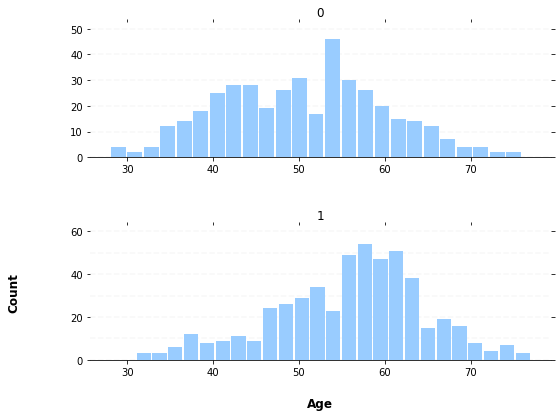

In [111]:
def plot_distributions_against_heart(variable):
    ax = data.hist(column=variable, by=heart_class, bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color=variable_colour[variable], zorder=2, rwidth=0.9)
    
    for i,x in enumerate(ax):
    
        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)
    
        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
    
        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)
    
        # Set x-axis label
        x.set_xlabel(variable, labelpad=20, weight='bold', size=12)
    
        # Set y-axis label
        if i == 1:
            x.set_ylabel("Count", labelpad=50, weight='bold', size=12)
    
        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    
        x.tick_params(axis='x', rotation=0)
        
    return x

age_heart_plot = plot_distributions_against_heart("Age")

There is a suggestion here that older age is associated more with heart failure

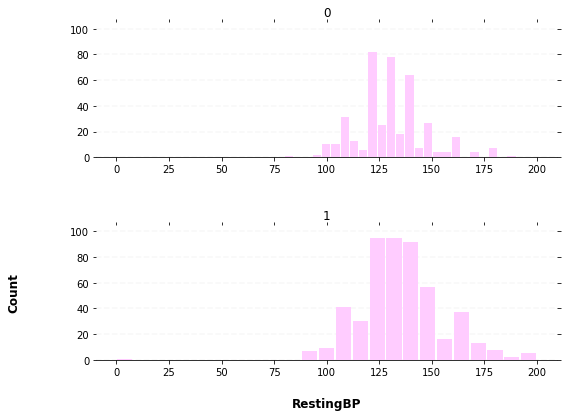

In [112]:
bp_heart_plot = plot_distributions_against_heart("RestingBP")

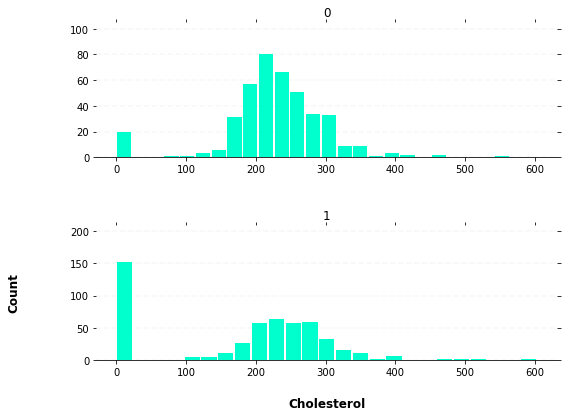

In [113]:
cholesterol_heart_plot = plot_distributions_against_heart("Cholesterol")

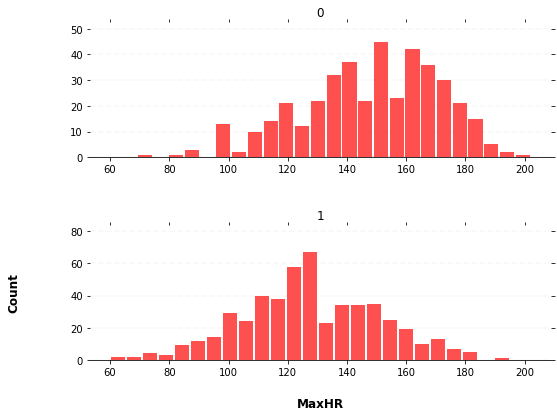

In [114]:
hr_heart_plot = plot_distributions_against_heart("MaxHR")

This graph suggests that heart failure classification is skewed to individuals with lower max heart rate.

How do these our binary variables differ by heart failure classification?

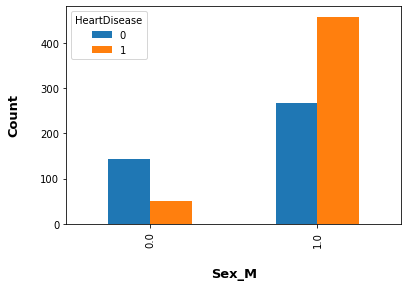

In [19]:
#rejoin class with data columns
data_with_class = data.copy()
data_with_class["HeartDisease"] = heart_class

def crosstab_plot(variable):
    ct_plot = pd.crosstab(index=data_with_class[variable], columns=data_with_class['HeartDisease'])
    
    x = ct_plot.plot(kind='bar', stacked=False)

    
    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        #x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("")
    
        # Set x-axis label
        x.set_xlabel(variable, labelpad=20, weight='bold', size=13)
    
        # Set y-axis label
        x.set_ylabel("Count", labelpad=20, weight='bold', size=13)
    
        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    return x

crosstab_plot("Sex_M")

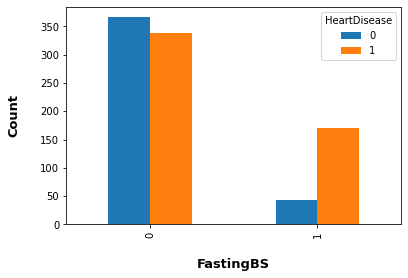

In [117]:
crosstab_plot("FastingBS")

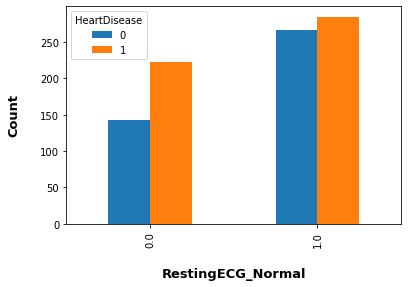

In [118]:
crosstab_plot("RestingECG_Normal")

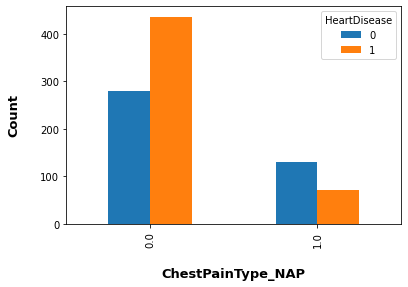

In [119]:
crosstab_plot("ChestPainType_NAP")

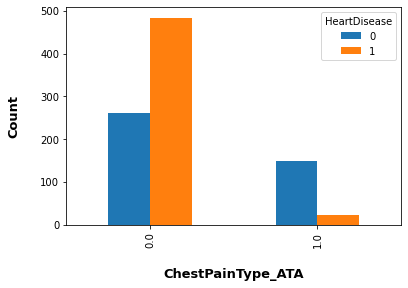

In [120]:
crosstab_plot("ChestPainType_ATA")

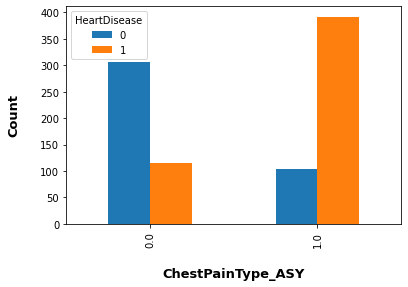

In [121]:
crosstab_plot("ChestPainType_ASY")

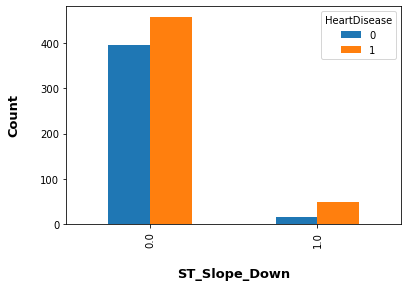

In [122]:
crosstab_plot("ST_Slope_Down")

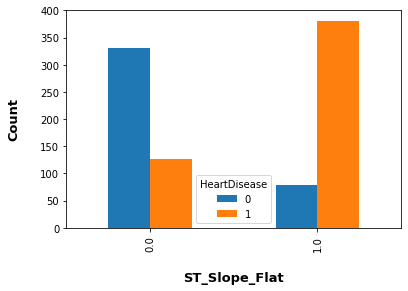

In [123]:
crosstab_plot("ST_Slope_Flat")

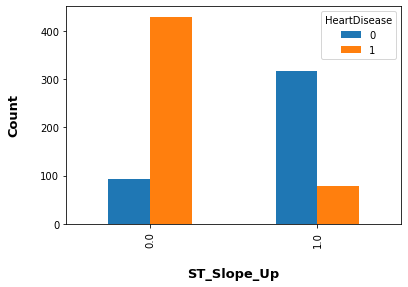

In [124]:
crosstab_plot("ST_Slope_Up")

There is a suggestion that there is a greater association of heart failure in men compared to women. FastingBS, ChestTypePain_ASY, ST_Slope_Flat also present similarly.

We will explore how these variables are associated with heart failure, as well as eachother using correlation heatmaps.

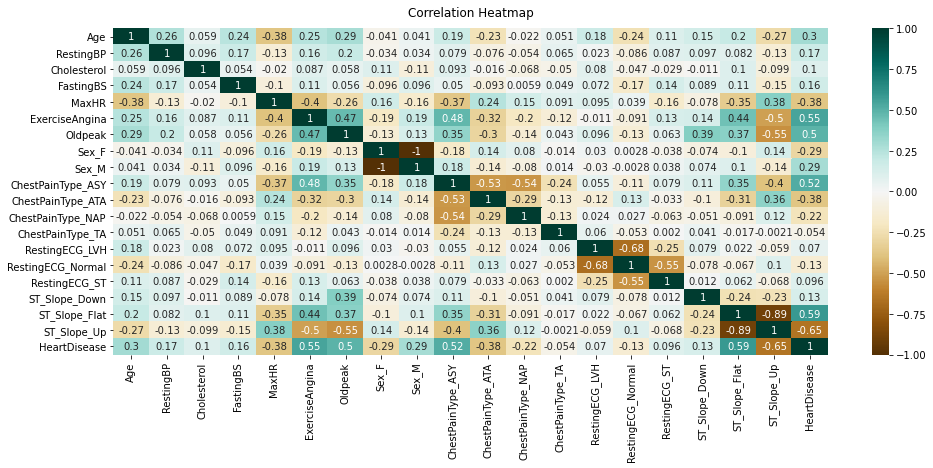

In [20]:
import seaborn as sns

# cholesterol column has many cells without information - Remove these
data_with_class_zeros_removed = data_with_class.copy()
data_with_class_zeros_removed = data_with_class_zeros_removed[data_with_class_zeros_removed.Cholesterol != 0]

data_with_class_zeros_removed.corr()

#make figure
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data_with_class_zeros_removed.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Our heatmap indicates that ST_Slope_Flat, ExerciseAngina, ChestPainType_ASY and Oldpeak, have the strongest association with heart failure classification (labelled HeartDisease here).

# Model Exploration

We will consider four different algorithms in our analysis: Logistic Regression, Boosting, Support Vector Machine and K-Nearest Neighbour. 

In [ ]:
############################################################################
# Algorithms
############################################################################

# Boosting
def boosting_classification_model(data, classes, n_estimator_value):
    #make pipeline for our different parameters
    pipeline1 = Pipeline([
        ('clf',  AdaBoostClassifier(n_estimators = n_estimator_value))
    ])
    
    classes = np.array(classes)
    
    #k-folds cross validation
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)
    acc_scores = cross_val_score(pipeline1, data, classes, cv=rkf, scoring="accuracy")
    s_acc = pd.Series(acc_scores)
    return s_acc.mean()


# support vector machine 
def svm_classification_model(data, classes, alpha_value, max_iter_value):
    #make pipeline for our different parameters
    pipeline2 = Pipeline([
        ('clf', SGDClassifier(alpha = alpha_value, max_iter = max_iter_value))
    ])
    
    classes = np.array(classes)
    
    #k-folds cross validation
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)
    acc_scores = cross_val_score(pipeline2, data, classes, cv=rkf, scoring="accuracy")
    s_acc = pd.Series(acc_scores)
    return s_acc.mean()

# k-nearest neighbours
def knn_classification_model(data, classes, n_neighbours_value):
    #make pipeline for our different parameters
    pipeline1 = Pipeline([
        ('clf', KNeighborsClassifier(n_neighbors = n_neighbours_value))
    ])
    
    classes = np.array(classes)
    
    #k-folds cross validation
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)
    acc_scores = cross_val_score(pipeline1, data, classes, cv=rkf, scoring="accuracy")
    s_acc = pd.Series(acc_scores)
    return s_acc.mean()

# logistic regression
def logistic_regression_model(data, classes, max_iter_value):
    #make pipeline for our different parameters
    pipeline1 = Pipeline([
        ('clf', LogisticRegression(max_iter=max_iter_value, class_weight='balanced'))
    ])
    
    classes = np.array(classes)
    
    #k-folds cross validation
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)
    acc_scores = cross_val_score(pipeline1, data, classes, cv=rkf, scoring="accuracy")
    s_acc = pd.Series(acc_scores)
    return s_acc.mean()



boosting_accuracy = boosting_classification_model(outlier_clean_data, outlier_clean_heart_class, 50)
svm_accuracy = svm_classification_model(outlier_clean_data, outlier_clean_heart_class, 0.0001, 1000)
knn_accuracy = knn_classification_model(outlier_clean_data, outlier_clean_heart_class, 3)
lr_accuracy = logistic_regression_model(outlier_clean_data, outlier_clean_heart_class, 300)

Look at accuracy scores for our models

In [22]:
print("Boosting Accuracy: ", boosting_accuracy)
print("SVM Accuracy: ", svm_accuracy)
print("KNN Accuracy: ", knn_accuracy)
print("LR Accuracy: ", lr_accuracy)

Boosting Accuracy:  0.847808219178082
SVM Accuracy:  0.6320547945205478
KNN Accuracy:  0.6386301369863013
LR Accuracy:  0.8646575342465753


We see that Logistic Regression and Boosting work very well with our dataset. This is due to the dataset being in a format suitable for these algorithms. Both Support Vector Machine and K-Nearest Neighbours works best when we normalise our continuous variables to a scale between 0,1. We should handle the two pairs of models differently from this perspective, ensuring that each works on data in the optimal format. 

Additionally, we have not applied any Hyperparameter Tuning to any of our models.

Let's evaluate the effect that normalising our dataset has on SVM and KNN accuracy scores:

In [23]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(outlier_clean_data)

normalised_data = scaler.transform(outlier_clean_data)


normalised_svm_accuracy = svm_classification_model(normalised_data, outlier_clean_heart_class, 0.0001, 1000)
normalised_knn_accuracy = knn_classification_model(normalised_data, outlier_clean_heart_class, 3)

print("SVM with normalisation: ", normalised_svm_accuracy)
print("KNN with normalisation: ", normalised_knn_accuracy)
print("Boosting Accuracy: ", boosting_accuracy)
print("LR Accuracy: ", lr_accuracy)

SVM with normalisation:  0.8290410958904105
KNN with normalisation:  0.844657534246575
Boosting Accuracy:  0.847808219178082
LR Accuracy:  0.8646575342465753


Performance accuracy is now comparable to Boosting and Logistic Regression

# Ensemble Model (without Hyperparameter Tuning)

We will incorporate these four algorithms into an ensemble model and evaluate their individual and cumulative predictive performance. Our strategy employed here considers transformations for the algorithm type in the ensemble; i.e. KNN and SVM will work with normalised data, whereas LR and Boosting will work on the standard dataset.

An important modification to the Logistic Regression algorithm is that we have set class_weight='balanced' and fit_intercept=False. We have modified fit_intercept in this way as this is more suitable to handle One-Hot-Encoded variables, compared to Dummy Encoded variables.

Notably, we have adjusted the weights in the ensemble, such that LR and KNN have more power in the prediction, as these are our models which have demonstrated the greatest predictive performance.

>Boosting: 0.847 (0.027)
>SVM: 0.826 (0.048)
>KNN: 0.855 (0.025)
>Logistic Regression: 0.857 (0.026)
>Ensemble: 0.859 (0.025)


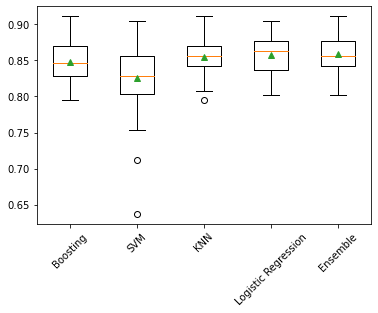

In [24]:
#########################################################################################
# ensemble strategy which considers data transformation for different models
#########################################################################################

# get a voting ensemble of models
def get_ensemble():
	# define the base models
    models = list()
    # Boosting (no normalisation)
    boosting = Pipeline([('m', AdaBoostClassifier())])
    models.append(('Boosting', boosting))
    	
    # SVM normalization
    svm = Pipeline([('s', MinMaxScaler(feature_range = (0,1))), ('m', SGDClassifier())])
    models.append(('SVM', svm))
    
    # KNN normalization
    knn = Pipeline([('s', MinMaxScaler(feature_range = (0,1))), ('m', KNeighborsClassifier())])
    models.append(('KNN', knn))
    
    # Logistic Regression (no normalization)
    logr = Pipeline([('m', LogisticRegression(class_weight='balanced', fit_intercept=False))])
    models.append(('Logistic Regression', logr))
    
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='hard', weights=[0.9,0.9,1.1,1.1]) # weights give LR more power
    return models + [('Ensemble', ensemble)]


models = get_ensemble()
# evaluate each model
results = list()
mean_results = list()
for name,model in models:
    # define the evaluation method
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
    # evaluate the model on the dataset
    n_scores = cross_val_score(model, outlier_clean_data, outlier_clean_heart_class, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))
    mean_results.append('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))
    results.append(n_scores)
# plot the results for comparison
plt.boxplot(results, labels=[n for n,_ in models], showmeans=True)
plt.xticks(rotation=45)
plt.show()

Significantly, we see that our Ensemble model scored the highest average accuracy (0.859), whereas, our KNN function which performs only slightly worse has the lowest standard deviation of accuracy.

We will evaluate the effect Hyperparameter Tuning has on accuracy.

# Ensemble Model (with Hyperparameter Tuning)

First we must tune the models on the normalised and standard datasets

In [25]:
#split our datasets
normalised_train, normalised_test, heart_class_train, heart_class_test = train_test_split(normalised_data, outlier_clean_heart_class, test_size=0.3, stratify=outlier_clean_heart_class, random_state = 1)
standard_train, standard_test, standard_heart_class_train, standard_heart_class_test = train_test_split(outlier_clean_data, outlier_clean_heart_class, test_size=0.3, stratify=outlier_clean_heart_class, random_state = 1)

In [26]:
###############################################
# K-Nearest Neighbours
###############################################

knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {'n_neighbors': np.arange(1, 50),
              'weights':['distance']}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(normalised_train, heart_class_train)

#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_) #12

{'n_neighbors': 12, 'weights': 'distance'}


In [27]:
###############################################
# Support Vector Machine
###############################################

svm = SGDClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_svm = {'alpha': np.arange(0.00005, 0.001, .00005),
              'max_iter': np.arange(500, 8000, 500)}
#use gridsearch to test all values for n_neighbors
svm_gs = GridSearchCV(svm, params_svm, cv=5)
#fit model to training data
svm_gs.fit(normalised_train, heart_class_train)

#save best model
svm_best = svm_gs.best_estimator_
#check best svm value
print(svm_gs.best_params_) # alpha = 0.00065, max_iter = 7500



{'alpha': 0.0006500000000000001, 'max_iter': 7500}


In [ ]:
###############################################
# Logistic Regression
###############################################

lr = LogisticRegression()
#create a dictionary of all values we want to test for n_neighbors
params_lr = {'max_iter': np.arange(0, 1000, 20),
             'class_weight':['balanced'], 
             'fit_intercept':[False]}
#use gridsearch to test all values for n_neighbors
lr_gs = GridSearchCV(lr, params_lr, cv=5)
#fit model to training data
lr_gs.fit(standard_train, standard_heart_class_train)

#save best model
lr_best = lr_gs.best_estimator_

In [29]:
#check best lr value
print(lr_gs.best_params_) #40

{'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 40}


In [30]:
###############################################
# Boosting
###############################################
boosting = AdaBoostClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_boosting = {'n_estimators': np.arange(5, 50, 1)}
#use gridsearch to test all values for n_neighbors
boosting_gs = GridSearchCV(boosting, params_boosting, cv=5)
#fit model to training data
boosting_gs.fit(standard_train, standard_heart_class_train)

#save best model
boosting_best = boosting_gs.best_estimator_
#check best boosting value
print(boosting_gs.best_params_) #15

{'n_estimators': 15}


Now we modify our ensemble function to include our tuned hyperparameters

In [32]:
#########################################################################################
# Ensemble with hyperparameter tuned models
#########################################################################################

# get a voting ensemble of models
def get_ensemble_HP():
	# define the base models
    models = list()
    # Boosting (no normalisation)
    boosting = Pipeline([('m', AdaBoostClassifier(n_estimators = 15))])
    models.append(('Boosting', boosting))
    
    # SVM normalization
    svm = Pipeline([('s', MinMaxScaler(feature_range = (0,1))), ('m', SGDClassifier(alpha = 0.00065, max_iter = 7500))])
    models.append(('SVM', svm))
    
    # KNN normalization
    knn = Pipeline([('s', MinMaxScaler(feature_range = (0,1))), ('m', KNeighborsClassifier(n_neighbors = 12, weights = 'distance'))])
    models.append(('KNN', knn))
    
    # Logistic Regression (no normalization)
    logr = Pipeline([('m', LogisticRegression(max_iter = 40, class_weight='balanced', fit_intercept=False))])
    models.append(('Logistic Regression', logr))
    
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='hard', weights=[1,1,1.2,1.2]) # weights give SVM and LR more power
    return models + [('ensemble', ensemble)]


models = get_ensemble_HP()

>Boosting: 0.845 (0.026)
>SVM: 0.856 (0.024)
>KNN: 0.860 (0.025)
>Logistic Regression: 0.856 (0.027)
>ensemble: 0.862 (0.026)


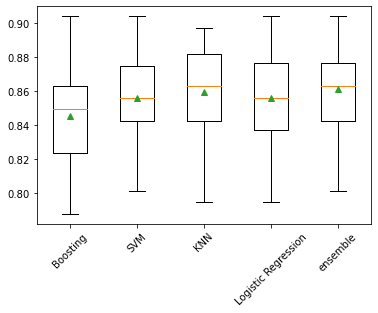

In [34]:
# evaluate each model
results = list()
HP_mean_results = list()
for name,model in models:
    	# define the evaluation method
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)
    	# evaluate the model on the dataset
    n_scores = cross_val_score(model, outlier_clean_data, outlier_clean_heart_class, scoring='accuracy', cv=cv, n_jobs=-1)
    	# report performance
    print('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))
    HP_mean_results.append('>%s: %.3f (%.3f)' % (name, mean(n_scores), std(n_scores)))
    results.append(n_scores)
# plot the results for comparison
plt.boxplot(results, labels=[n for n,_ in models], showmeans=True)
plt.xticks(rotation=45)
plt.show()

We will conclude this analysis by looking at how well our ensemble works on the total dataset now. We will train our ensemble on the total test set and then evaluate accuracy on the unseen test data.

In [ ]:
#############################################################
# Test on withheld data
#############################################################

estimators = models.copy()
estimators=estimators[:-1]

#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(standard_train, standard_heart_class_train )
#test our model on the test data
ensemble_score = ensemble.score(standard_test, standard_heart_class_test)

In [49]:
print(ensemble_score)

0.8493150684931506


# Conclusions

After suitable data cleaning, feature engineering and data transformation, our four chosen algorithms can predict incidence of heart failure with significant accuracy (lowest average accuracy is Boosting with 0.845). Incorporating these four models into an ensemble also was able to improve accuracy significantly, with the ensemble performing on average better than the individual models. This performance accuracy could further be increased with some tuning of our model hyperparameters. Standard deviation was similar between all the models.

Accuracy was maximised at 0.862 as seen through cross validation. This ensemble when evaluated on the unseen test set scored an accuracy of 0.849.

It would be interesting to repeat this analysis, however, instead of removing missing Cholesterol rows, removing Cholesterol in its entirety. This would allow analysis with an enlarged dataset. 